Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import io
import numpy as np
import pandas as pd
import os
from glob import glob
import random

import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [26]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [31]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/My Drive/cnn/Data/Train/")
data_dir_test = pathlib.Path('/content/drive/My Drive/cnn/Data/Test/')

In [32]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2237
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [29]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [33]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    image_size=(img_height,img_width),
    subset="training",
    validation_split=0.2,
    #batch_size=batch_size,
    label_mode='int'
)

train_ds = dataset_train

Found 2237 files belonging to 9 classes.
Using 1790 files for training.


In [34]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
dataset_val = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    image_size=(img_height,img_width),
    subset="validation",
    validation_split=0.2,
    #batch_size=batch_size,
    label_mode='int'
)
val_ds = dataset_val

Found 2237 files belonging to 9 classes.
Using 447 files for validation.


In [35]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

AttributeError: 'function' object has no attribute 'glob'

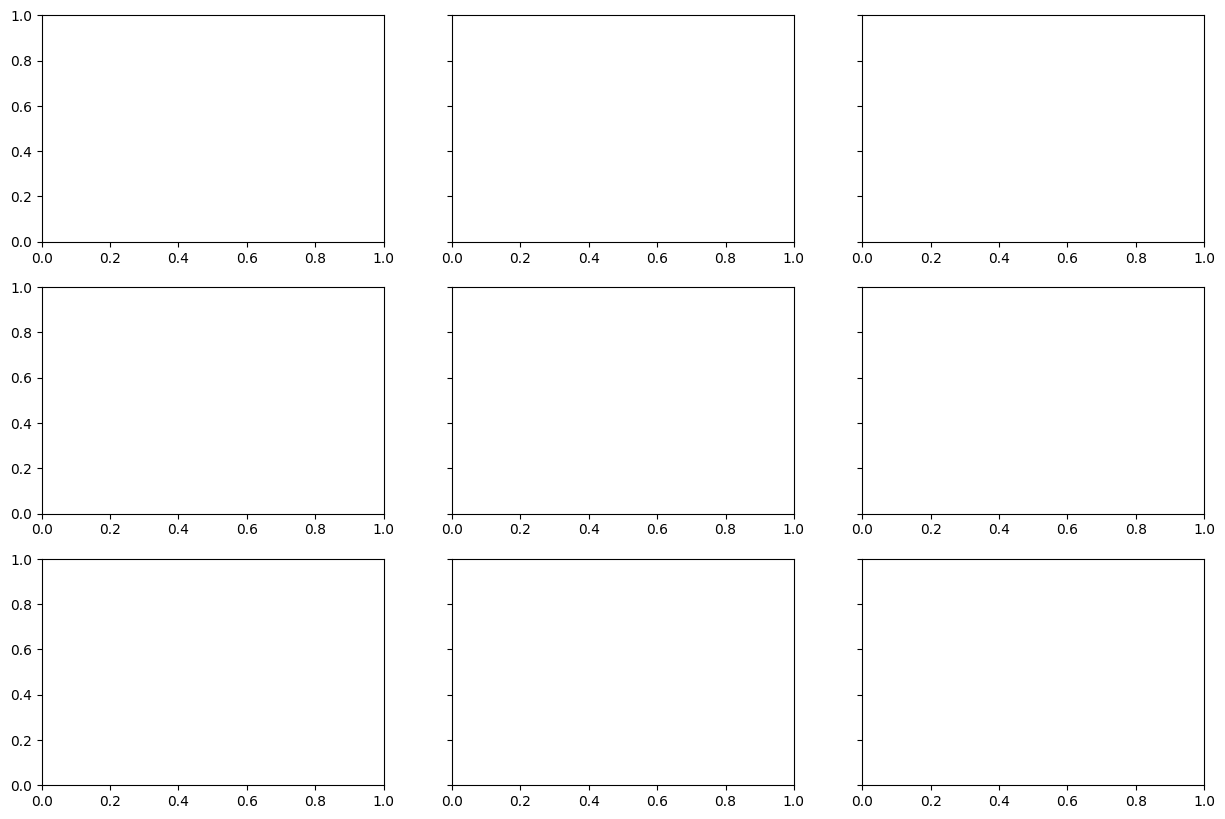

In [36]:
import matplotlib.pyplot as plt

f, axs = plt.subplots(3, 3, sharey=True)
f.set_figwidth(15)
f.set_figheight(10)

for i in range(0,9):
  skin_desease = os.path.join(data_dir_train, class_names[i], '*')
  skin_desease = glob.glob(skin_desease)
  rand_index = random.randint(0, len(skin_desease)-1)
  image = io.imread(skin_desease[rand_index])
  axs[int(i/3),int(i%3)].imshow(image)
  axs[int(i/3),int(i%3)].set_title(class_names[i])


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [37]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [38]:
### Your code goes here
from tensorflow.keras.layers import Rescaling

rescale_layer = Rescaling(scale=1.0/255)

def preprocess(image, label):
  """Preprocesses the image and label."""
  # Resize the image
  image = rescale_layer(image)
  #image = tf.image.resize(image, [180, 180])
  # One-hot encode the label
  label = tf.cast(label,tf.int32)
  label = tf.one_hot(label, depth=len(class_names))
  return image, label

train_ds = train_ds.unbatch()
val_ds = val_ds.unbatch()
train_ds = train_ds.map(preprocess).batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [39]:
### Todo, choose an appropirate optimiser and loss function
# model
model = Sequential()

# a keras convolutional layer is called Conv2D
# help(Conv2D)
# note that the first layer needs to be told the input shape explicitly

# first conv layer
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(180,180,3))) # input shape = (img_rows, img_cols, 1)

# second conv layer
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
#model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
# softmax layer
model.add(Dense(len(class_names), activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 176, 176, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 88, 88, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 495616)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      63,438,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,529,033 (242.34 MB)

 Trainable params: 63,529,033 (242.34 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [41]:
epochs = 20


history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
     55/Unknown 669s 60ms/step - accuracy: 0.1819 - loss: 7.5345

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


55/55 ━━━━━━━━━━━━━━━━━━━━ 831s 3s/step - accuracy: 0.1824 - loss: 7.4697 - val_accuracy: 0.3582 - val_loss: 2.0282
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.3345 - loss: 1.9021 - val_accuracy: 0.4639 - val_loss: 1.5169
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.4708 - loss: 1.5787 - val_accuracy: 0.4087 - val_loss: 1.6959
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.4670 - loss: 1.6323 - val_accuracy: 0.5385 - val_loss: 1.4348
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.5348 - loss: 1.3883 - val_accuracy: 0.5288 - val_loss: 1.3573
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.5496 - loss: 1.2682 - val_accuracy: 0.5312 - val_loss: 1.3608
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.6314 - loss: 1.0895 - val_accuracy: 0.5216 - val_loss: 1.4692
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.6192 - loss: 1.0907 - val_accuracy: 0.4856 - val_loss: 1

### Visualizing training results

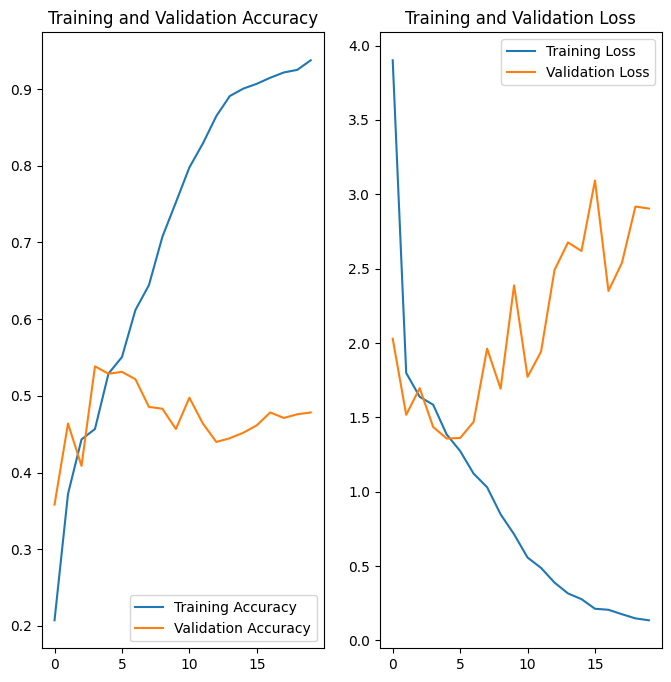

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

# As can be seen model is over fitted as validation accuracy is not improving with increase in training accuracy
# we can use augmentation strategy to address it

In [50]:



from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1)
image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

#  Example usage
# augmented_data = datagen.flow_from_directory(
#     data_dir_train,
#     target_size=(180, 180),
#     seed=123,
#     classes=image_class,
#     #batch_size=32,
#     class_mode='categorical'
# )

train_batches = datagen.flow_from_directory(data_dir_train,
    target_size = (180,180),
    classes = image_class,
    batch_size = 32
 )

valid_batches = datagen.flow_from_directory(data_dir_test,
    target_size = (180,180),
    classes = image_class,
    batch_size = 32
)



Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


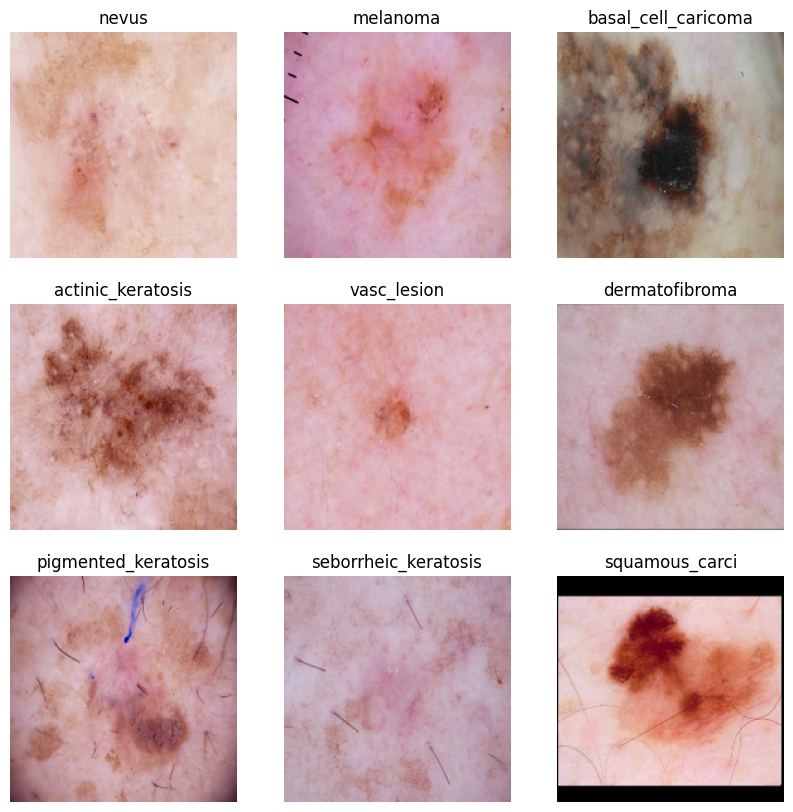

In [51]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(image_class[i])
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [52]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
### Todo, choose an appropirate optimiser and loss function
# model
model = Sequential()

# a keras convolutional layer is called Conv2D
# help(Conv2D)
# note that the first layer needs to be told the input shape explicitly

# first conv layer
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(180,180,3))) # input shape = (img_rows, img_cols, 1)


# second conv layer
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.2))

# softmax layer
model.add(Dense(len(class_names), activation='softmax'))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compiling the model

In [53]:
## Your code goes here

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

### Training the model

In [54]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20


history = model.fit(
  train_batches,
  validation_data=valid_batches,
  epochs=epochs
)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4157 - loss: 1325.5031 - val_accuracy: 0.3958 - val_loss: 2.2108
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 732ms/step - accuracy: 0.4496 - loss: 2.4594 - val_accuracy: 0.3333 - val_loss: 2.5154
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 692ms/step - accuracy: 0.5444 - loss: 1.8386 - val_accuracy: 0.2292 - val_loss: 1.9290
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 665ms/step - accuracy: 0.5119 - loss: 1.6728 - val_accuracy: 0.2917 - val_loss: 5.5434
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 741ms/step - accuracy: 0.4854 - loss: 1.5303 - val_accuracy: 0.3333 - val_loss: 1.6590
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 651ms/step - accuracy: 0.5056 - loss: 1.3631 - val_accuracy: 0.2917 - val_loss: 1.5426
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 43s 735ms/step - accuracy: 0.5330 - loss: 1.1639 - val_accuracy: 0.3333 - val_loss: 1.5758
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 627ms/step - accuracy: 0.5288 - loss: 1.1319 - val_accu

### Visualizing the results

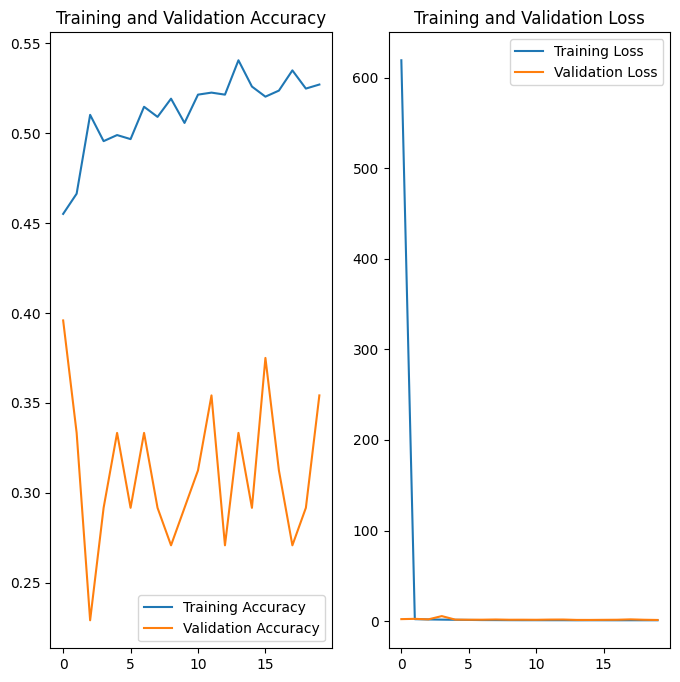

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

After performing augmentation, now training and test accuracy gap has reduced

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [56]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

class_dist = class_distribution_count(data_dir_train)
class_dist

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,374
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139



#### - seborrheic keratosis	 has least number of samples
#### - pigmented benign keratosis	 dominates other classes


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [57]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [59]:
path_to_training_dataset="/content/drive/My Drive/cnn/Data/Train/"
import Augmentor
for i in class_names:
    #print(path_to_training_dataset + i)
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/cnn/Data/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A456FFF0340>: 100%|██████████| 500/500 [00:28<00:00, 17.63 Samples/s]


Initialised with 374 image(s) found.
Output directory set to /content/drive/My Drive/cnn/Data/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A458059AFB0>: 100%|██████████| 500/500 [00:18<00:00, 26.44 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/cnn/Data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A45A460B070>: 100%|██████████| 500/500 [00:19<00:00, 25.54 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/cnn/Data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2592x1944 at 0x7A459C4F7070>: 100%|██████████| 500/500 [01:31<00:00,  5.48 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/cnn/Data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A459C352E00>: 100%|██████████| 500/500 [01:22<00:00,  6.04 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/cnn/Data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A459DF8E350>: 100%|██████████| 500/500 [00:18<00:00, 26.65 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/cnn/Data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A456FFF2D40>: 100%|██████████| 500/500 [00:38<00:00, 13.04 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/cnn/Data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A45A45E3820>: 100%|██████████| 500/500 [00:18<00:00, 26.37 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/cnn/Data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A45A46E79D0>: 100%|██████████| 500/500 [00:21<00:00, 23.18 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [60]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [61]:
print(data_dir_train)
path_list_orig = [x for x in glob(os.path.join(data_dir_train, '*','*.jpg'))]
len(path_list_orig)

/content/drive/My Drive/cnn/Data/Train


2237

In [62]:
lesion_list_orig = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(lesion_list_orig)

2237

In [63]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(lesion_list_new)

4500

In [64]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(path_list_new)

4500

In [65]:

dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
len(dataframe_dict_new)

4500

In [66]:

original_dict = dict(zip(path_list_orig, lesion_list_orig))
original_df = pd.DataFrame(list(original_dict.items()),columns = ['Path','Label'])
original_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,462
melanoma,438
basal cell carcinoma,374
nevus,357
squamous cell carcinoma,181
vascular lesion,139
actinic keratosis,114
dermatofibroma,95
seborrheic keratosis,77


In [67]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2['Label'].value_counts()
new_df =  pd.concat( [original_df,df2],axis=0)
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,874
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [68]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [69]:
data_dir_train=data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6737 files belonging to 9 classes.
Using 5390 files for training.


#### **Todo:** Create a validation dataset

In [70]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6737 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [71]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
### Todo, choose an appropirate optimiser and loss function
# model
model = Sequential()

# a keras convolutional layer is called Conv2D
# help(Conv2D)
# note that the first layer needs to be told the input shape explicitly

# first conv layer
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(180,180,3))) # input shape = (img_rows, img_cols, 1)


# second conv layer
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.2))

# softmax layer
model.add(Dense(len(class_names), activation='softmax'))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [72]:
## Your code goes here

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 256ms/step - accuracy: 0.8946 - loss: 0.3487 - val_accuracy: 0.5509 - val_loss: 2.6098
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 246ms/step - accuracy: 0.8963 - loss: 0.3299 - val_accuracy: 0.5457 - val_loss: 2.4326
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 243ms/step - accuracy: 0.9011 - loss: 0.3393 - val_accuracy: 0.5405 - val_loss: 2.3865
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 242ms/step - accuracy: 0.9073 - loss: 0.4002 - val_accuracy: 0.5516 - val_loss: 2.6845
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 240ms/step - accuracy: 0.9196 - loss: 0.2881 - val_accuracy: 0.5197 - val_loss: 2.2564
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 254ms/step - accuracy: 0.9138 - loss: 0.2823 - val_accuracy: 0.5575 - val_loss: 2.8448
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 248ms/step - accuracy: 0.9202 - loss: 0.3046 - val_accuracy: 0.5590 - val_loss: 2.9342
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 83s 253ms/step - accuracy: 0.9139 - loss: 0

#### **Todo:**  Visualize the model results

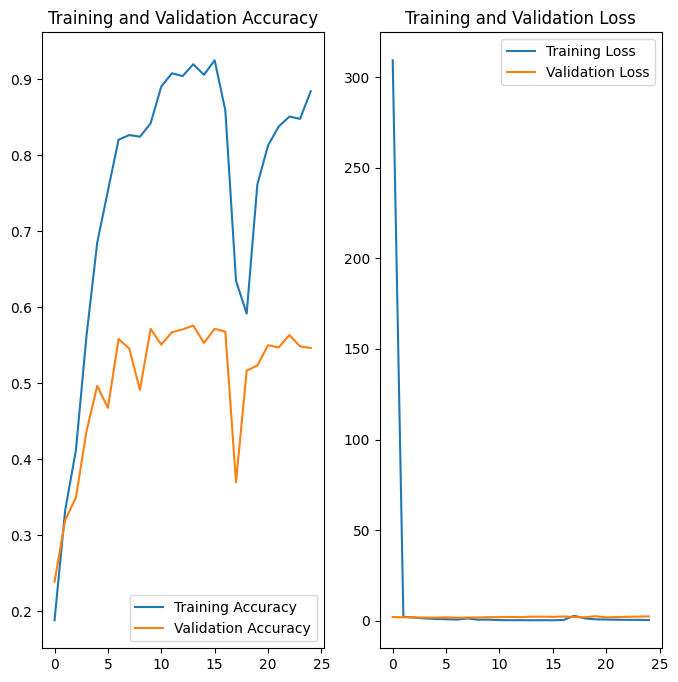

In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



By performing augmentation gap between training and validation accuracy is narrowed, which shows it helped in overcoming overfitting

By addressing class imbalance we see the accuracy have improved